In [1]:
import torch
import numpy as np
from torch import nn, Tensor

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, RandomSampler
from torchvision.datasets import CIFAR10
import os
import time

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
root = "./datasets"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

train_dataset = CIFAR10(root, 
                      train=True, 
                      download=True,
                      transform=transform)

test_dataset = CIFAR10(root, 
                     train=False, 
                     download=True,
                     transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4096, shuffle=False)


dataset = []
labels = []
for x, y in train_loader:
    dataset.append(x.reshape(-1, 3*32*32))
    labels.append(Tensor(y).view(-1, 1))
dataset = torch.cat(dataset, dim=0).to(device)
labels = torch.cat(labels, dim=0).to(device)
dataset.shape, labels.shape

Files already downloaded and verified
Files already downloaded and verified


(torch.Size([50000, 3072]), torch.Size([50000, 1]))

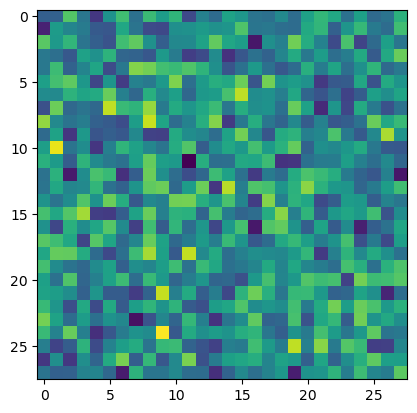

In [6]:
class CondFlow(nn.Module):
    def __init__(self, dim, h):
        super().__init__()
        self.dim = dim
        self.net = nn.Sequential(
            nn.Linear(dim + 2, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim)
        )
    
    def forward(self, t, c, x):
        return self.net(torch.cat((t, c, x), dim=-1))
    
    def step(self, x, c, t_start, t_end):
        t_start = t_start.view(1, 1).expand(x.shape[0], 1)
        t_end = t_end.view(1, 1).expand(x.shape[0], 1)
        
        t_mid = (t_end + t_start) / 2
        x_mid = x + self.forward(t=t_start, c=c, x=x) * (t_mid - t_start)
        return  x + self.forward(t=t_mid, c=c, x=x_mid) * (t_end - t_start)

model = CondFlow(784, 64).to(device)

x_0 = torch.randn(1, 784).to(device)
c = Tensor([[1.0]]).to(device)
t = torch.rand(len(x_0), 1).to(device)
x_1 = model(t, c, x_0).view(28, 28)
plt.imshow(x_1.detach().cpu().numpy())


In [7]:
def train_conditional(model, optimizer, loss_fn, epochs=2000, show_every=None, show_loss=False):
    model.train()
    losses = []
    
    if not show_every is None:
        show_loss = True
    
    for i in range(epochs):
        s = time.time()
        x_1 = dataset
        c = labels
        x_0 = torch.randn_like(x_1).to(device)
        t = torch.rand(x_1.shape[0], 1).to(device)

        x_t = (1 - t) * x_0 + t * x_1
        dx_t = x_1 - x_0

        v = model(t=t, c=c, x=x_t)
        loss = loss_fn(v, dx_t)
        losses.append(loss.detach().item())

        if show_loss and i % show_every == 0:
            print(f"Epoch: {i}, Loss: {losses[i]:.4f}, Time: {(time.time() - s):.2f}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses


Epoch: 0, Loss: 1.2691, Time: 6.18
Epoch: 1, Loss: 1.2741, Time: 3.46
Epoch: 2, Loss: 1.2607, Time: 6.74


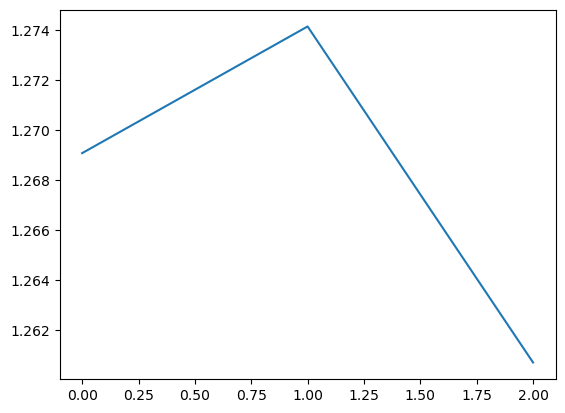

In [ ]:
flow = CondFlow(3*32*32, 32).to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
loss = torch.nn.MSELoss()
losses = train_conditional(flow, optimizer, loss, epochs=5000, show_every=500)
plt.plot(losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49849808..0.5849865].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4483642..0.40573716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.43864828..0.3822231].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45960578..0.45126933].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40105945..0.40243074].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48412755..0.44084525].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [

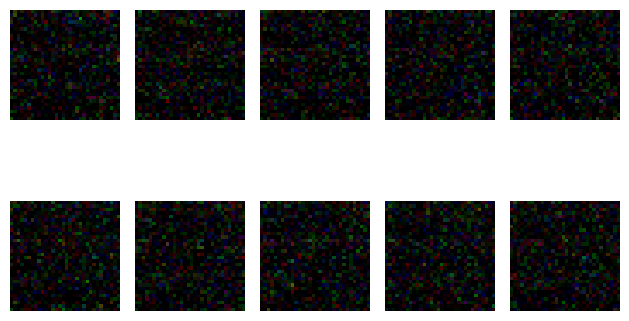

In [10]:
n_steps = 10
sigma = 0.1
x = sigma * torch.randn(10, flow.dim).to(device)
c = 0
c = Tensor([[c + (1)*i] for i in range(10)]).to(device)
# c = Tensor([[c]]*10).to(device)
time_steps = torch.linspace(0.0, 1.0, n_steps + 1).to(device)
for i in range(n_steps):
    x = flow.step(x=x, c=c, t_start=time_steps[i], t_end=time_steps[i+1])
x = x.view(-1, 32, 32, 3).detach().cpu().numpy()

_, ax = plt.subplots(2, 5)
for i in range(10):
    ax[i//5][i%5].axis("off")
    ax[i//5][i%5].imshow(x[i])
plt.tight_layout()